In [70]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


# Random forest modelling
### Note: outliers are included in this script as they don't affect RF models

In [71]:
data = pd.read_csv('england/with_density_no_outliers.csv')

# remove thousands separator (eg. 1,000)
data['population_density'] = data['population_density'].str.replace(',', '')

In [72]:
data.head()

,lsoa11,population_density,year,loneills,lsoa_name,district_code,district_name,imd_score,imd_rank,imd_decile,...,indoor_sub_rank,indoor_sub_decile,outdoor_sub_score,outdoor_sub_rank,outdoor_sub_decile,total_population,aged_under_15_population,aged_16-59_population,aged_over_60_population,working_age_population
0,E01020636,1886,2015,0.651901,County Durham 001C,E06000047,County Durham,21.632,12979.0,4.0,...,32265.0,10.0,-1.482,31684.0,10.0,1704.0,306.0,956.0,442.0,976.50
1,E01020629,3270,2015,0.299419,County Durham 003C,E06000047,County Durham,19.084,14979.0,5.0,...,25589.0,8.0,-1.215,30432.0,10.0,1488.0,304.0,836.0,348.0,839.25
2,E01020655,242,2015,-0.231131,County Durham 003D,E06000047,County Durham,11.477,22411.0,7.0,...,29921.0,10.0,-1.748,32368.0,10.0,2039.0,333.0,1115.0,591.0,1142.50
3,E01020661,2193,2015,-1.047568,County Durham 004A,E06000047,County Durham,27.441,9495.0,3.0,...,19737.0,7.0,-0.446,22845.0,7.0,1841.0,316.0,1046.0,479.0,1073.50
4,E01020615,2871,2015,-1.014707,County Durham 005B,E06000047,County Durham,39.224,4745.0,2.0,...,32597.0,10.0,-0.440,22773.0,7.0,1786.0,352.0,984.0,450.0,981.00


Perform a trivial train-test split. Cross validation is not needed in RF in theory.

In [80]:
train, test = train_test_split(data, test_size=0.2)

In [81]:
x_train = train.drop(['lsoa11', 'year', 'lsoa_name', 'district_code', 'district_name', 'loneills'], axis=1).iloc[:-1,:]
x_test = test.drop(['lsoa11', 'year', 'lsoa_name', 'district_code', 'district_name', 'loneills'], axis=1).iloc[:-1,:]
x_train.astype('float32')
x_test.astype('float32')

y_train = train['loneills'][:-1]
y_test = test['loneills'][:-1]

In [82]:
model = RandomForestRegressor()

In [83]:
model.fit(x_train, y_train)

RandomForestRegressor()

In [84]:
model.score(x_test, y_test)

0.08777501693520995

Really poor performance. Should we do hyperparameter tuning? Maybe not worth it.

In [78]:
importance = model.feature_importances_
features = x_train.columns
feature_importance = pd.DataFrame({'Feature': features, 'Importance': importance})

#order them by importance
feature_importance.sort_values(by=['Importance'], ascending=False, inplace=True)
feature_importance

,Feature,Importance
35,adult_skills_sub_rank,0.067813
50,aged_under_15_population,0.047775
40,wider_barriers_sub_score,0.040982
41,wider_barriers_sub_rank,0.040593
17,crime_rank,0.040412
0,population_density,0.039264
31,young_sub_score,0.038968
52,aged_over_60_population,0.037672
29,poor_older_rank,0.033788
46,outdoor_sub_score,0.028911


It looks like the features that have a bigger contributions adult_skills_sub_rank, aged_under_15_population, population_density...

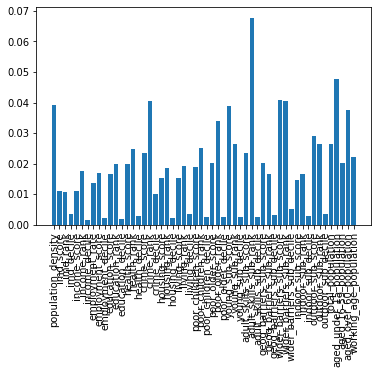

In [79]:
plt.bar(range(len(importance)),importance)
plt.xticks(range(len(importance)), features, rotation=90);